## Extracting SNPs contributing to a model

In [1]:
import os
import pickle
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
os.chdir('/media/HDD_4TB_1/jordi/cfuses_gnn_enrollhd_2024/')

In [3]:
# Data directory
data_dir = "data/features/"

# Path to regressors
reg_dir = "data/ml_results/regressors/"

# Path to output directory
out_dir = "data/ml_results/regressors_info/"

In [4]:
# Extract feature matrix header
with open(data_dir + "subsetting/header_feature_matrix_m3_filt_0.01_nodups.txt", "r") as file:
    header = file.readline().strip().split("\t")
        
feature_names = header[1:]

# Read SNP lookup table
snp_lookuptab = pd.read_csv("data/SNPs/snps_gene_GO_m3.txt", sep="\t")

## For least squares methods

In [28]:
# Name of pickled model file
regressor_file = 'elastic_net_regressor_bsc.pkl' # Lasso

# Extract model name string
regressor_name = regressor_file.split(sep = ".")[0]

In [29]:
# Load the pickled model
with open(reg_dir + regressor_file, 'rb') as f:
    regressor = pickle.load(f)

In [30]:
# Get how many coefficients different from 0
sum(1 for coef in regressor.coef_ if coef != 0)

1164

In [31]:
# Sort coefficients in descending order by their absolute value
non_zero_indices_values = [(index, coef, abs(coef)) for index, coef in enumerate(regressor.coef_) if coef != 0]
sorted_indices_values = sorted(non_zero_indices_values, key=lambda x: x[2], reverse=True)

Get what snps correspond to each index

In [32]:
# Keep only the feature corresponding to the index and signed 
# value of the sorted coefficients
model_coefs = []

for index, coef, _ in sorted_indices_values:
    model_coefs.append([feature_names[index], coef])

In [33]:
# If most important feature is CAG (will most 
# certainly be) print its coefficient

if model_coefs[0][0] == 'CAG':
    print('CAG coefficient is:', model_coefs[0][1])

CAG coefficient is: -3.2781513


In [34]:
# Assemble presenting table
model_snps = pd.DataFrame(columns=['SNP','Coefficient','Gene','GO'])

for snp, coef in model_coefs[1:]:
    # Find snp in lookup table
    match = snp_lookuptab[snp_lookuptab["SNP"] == snp]
    # Retrieve corresponding gene and GO term
    gene, GO = match['Gene'].values[0], match['GO_term'].values[0]
    # Create new row in pd df
    row = {'SNP':snp, 'Coefficient':coef, 'Gene':gene, 'GO':GO}
    model_snps = model_snps._append(row, ignore_index=True)

/tmp/ipykernel_425762/1903723015.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_snps = model_snps._append(row, ignore_index=True)


In [35]:
model_snps

,SNP,Coefficient,Gene,GO
0,rs11982878,3.365854e-02,PRKAG2,GO:0006112
1,rs12914843,3.142683e-02,FAN1,extra_genes
2,rs6585194,-2.999602e-02,TCF7L2,GO:0140110
3,rs12884411,-2.911162e-02,ESRRB,GO:0140110
4,rs45562534,2.601217e-02,MLH1,GO:0006298
...,...,...,...,...
1158,rs11594238,7.885882e-07,FOXP1,GO:0140110
1159,rs2039220,-4.592979e-07,PAX5,GO:0140110
1160,rs7073231,3.218443e-07,SIRT1,GO:0043161
1161,rs57484645,2.383647e-07,GYS2,GO:0006112


In [36]:
# Save final table to tab separated txt file
model_snps.to_csv(out_dir + regressor_name + '_coefs.txt', sep='\t', index=False)

## For tree based methods

### XGBoost models

In [13]:
# Name of pickled model file
xgb_booster_file = 'histXGBoost_regressor_bsc.pkl'
# xgb_booster_file = 'approxXGBoost_regressor_bsc.pkl'

# Extract model name string
xgb_booster_name = xgb_booster_file.split(sep = ".")[0]

In [14]:
# Load the pickled model
with open(reg_dir + xgb_booster_file, 'rb') as f:
    xgb_booster = pickle.load(f)

In [15]:
gain_importances = xgb_booster.get_booster().get_score(importance_type='gain')

In [9]:
weight_importances = xgb_booster.get_booster().get_score(importance_type='weight')

In [16]:
# Convert gain_importances dictionary to a list of lists
# removing the intial f of the key
gain_importances_list = [[feature_names[int(key[1:])], value] for key, value in gain_importances.items()]

In [17]:
# Sort in descending order
gain_importances_list = sorted(gain_importances_list, key=lambda x: x[1], reverse=True)

In [19]:
# If most important feature is CAG (will most 
# certainly be) print its coefficient

if gain_importances_list[0][0] == 'CAG':
    print('CAG coefficient is:', gain_importances_list[0][1])

CAG coefficient is: 275.13458251953125


In [20]:
# Assemble presenting table
booster_important_snps = pd.DataFrame(columns=['SNP','Gain','Gene','GO'])

# Take top 100 snps
for snp, gain in gain_importances_list[1:101]:
    # Find snp in lookup table
    match = snp_lookuptab[snp_lookuptab["SNP"] == snp]
    # Retrieve corresponding gene and GO term
    gene, GO = match['Gene'].values[0], match['GO_term'].values[0]
    # Create new row in pd df
    row = {'SNP':snp, 'Gain':gain, 'Gene':gene, 'GO':GO}
    booster_important_snps = booster_important_snps._append(row, ignore_index=True)

/tmp/ipykernel_431667/1342472698.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  booster_important_snps = booster_important_snps._append(row, ignore_index=True)


In [21]:
# Save final table to tab separated txt file
booster_important_snps.to_csv(out_dir + xgb_booster_name + '_coefs.txt', sep='\t', index=False)

----

Filter gains and weights to the top 5%.

In [15]:
# Sort the dictionaries based on values
sorted_weight_importances = dict(sorted(weight_importances.items(), key=lambda item: item[1], reverse=True))
sorted_gain_importances = dict(sorted(gain_importances.items(), key=lambda item: item[1], reverse=True))

# Calculate the number of features to retain (top 5%)
# num_features_to_retain = int(len(weight_importances) * 0.01)
num_features_to_retain = 100

# Get the top 10% entries
top_weight_importances = dict(list(sorted_weight_importances.items())[:num_features_to_retain])
top_gain_importances = dict(list(sorted_gain_importances.items())[:num_features_to_retain])

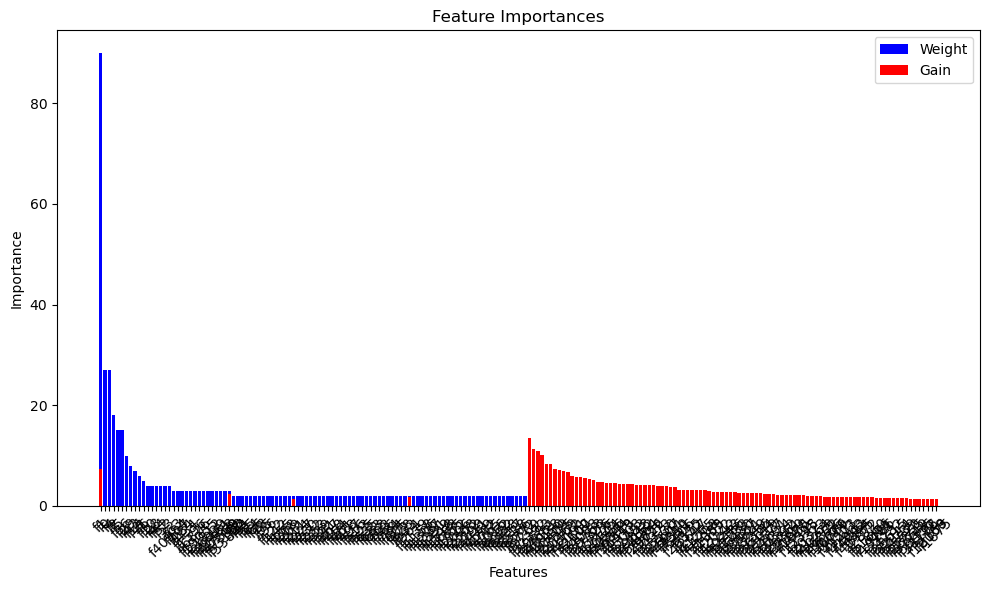

In [16]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_weight_importances.keys(), top_weight_importances.values(), color='blue', label='Weight')
plt.bar(top_gain_importances.keys(), top_gain_importances.values(), color='red', label='Gain')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Random Forest

In [9]:
# Name of pickled model file
rf_file = 'randomforest_regressor_bsc.pkl'

In [10]:
# Extract model name string
rf_name = rf_file.split(sep = ".")[0]
# Load the pickled model
with open(reg_dir + rf_file, 'rb') as f:
    rf_reg = pickle.load(f)

In [11]:
# Get feature importances (gini importance)
feat_importances = rf_reg.feature_importances_

In [61]:
# Sort ginis importance in descending order
non_zero_indices_values = [(index, coef) for index, coef in enumerate(feat_importances) if coef != 0]
sorted_indices_values = sorted(non_zero_indices_values, key=lambda x: x[1], reverse=True)

In [ ]:
# Keep only the feature corresponding to the index and signed 
# value of the sorted coefficients
model_ginis = []

for index, coef in sorted_indices_values:
    model_ginis.append([feature_names[index], coef])

In [ ]:
# If most important feature is CAG (will most 
# probably be) print its coefficient

if model_ginis[0][0] == 'CAG':
    print('CAG coefficient is:', model_ginis[0][1])

In [ ]:
# Assemble presenting table
model_snps = pd.DataFrame(columns=['SNP','Coefficient','Gene','GO'])

for snp, gini in model_ginis[1:]:
    # Find snp in lookup table
    match = snp_lookuptab[snp_lookuptab["SNP"] == snp]
    # Retrieve corresponding gene and GO term
    gene, GO = match['Gene'].values[0], match['GO_term'].values[0]
    # Create new row in pd df
    row = {'SNP':snp, 'GiniImportance':gini, 'Gene':gene, 'GO':GO}
    model_snps = model_snps._append(row, ignore_index=True)

In [ ]:
# Save final table to tab separated txt file
model_snps.to_csv(out_dir + regressor_name + '_coefs.txt', sep='\t', index=False)